In [145]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.stats as scs
from scipy.special import erfinv

In [146]:
def get_omega_mean(O_p,b):
    return (norm.pdf(O_p) - norm.pdf(b)) /(norm.cdf(b) - norm.cdf(O_p))

A = np.linspace(1,3,1000)
get_omega_mean(1,A) 

/var/folders/kn/fvpnhvjx5d363mgqcf9f1ltc0000gn/T/ipykernel_99742/971461361.py:2: RuntimeWarning: invalid value encountered in divide
  return (norm.pdf(O_p) - norm.pdf(b)) /(norm.cdf(b) - norm.cdf(O_p))


array([       nan, 1.00100067, 1.00200066, 1.00299999, 1.00399864,
       1.00499661, 1.00599391, 1.00699053, 1.00798646, 1.00898171,
       1.00997628, 1.01097015, 1.01196334, 1.01295583, 1.01394764,
       1.01493874, 1.01592915, 1.01691885, 1.01790786, 1.01889616,
       1.01988376, 1.02087064, 1.02185682, 1.02284229, 1.02382704,
       1.02481108, 1.0257944 , 1.026777  , 1.02775888, 1.02874003,
       1.02972046, 1.03070016, 1.03167913, 1.03265737, 1.03363488,
       1.03461166, 1.03558769, 1.03656299, 1.03753754, 1.03851136,
       1.03948442, 1.04045674, 1.04142832, 1.04239914, 1.04336921,
       1.04433852, 1.04530708, 1.04627488, 1.04724192, 1.0482082 ,
       1.04917371, 1.05013846, 1.05110244, 1.05206565, 1.05302808,
       1.05398975, 1.05495064, 1.05591075, 1.05687008, 1.05782863,
       1.0587864 , 1.05974338, 1.06069958, 1.06165498, 1.0626096 ,
       1.06356342, 1.06451645, 1.06546869, 1.06642012, 1.06737076,
       1.06832059, 1.06926962, 1.07021784, 1.07116526, 1.07211

In [147]:
norm.ppf(0.999)

3.090232306167813

# Check backward process graph

In [148]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

from numba import njit
from numba.types import intc, CPointer, float64
from numba import cfunc, carray, jit
from scipy import LowLevelCallable

from scipy.integrate import quad
from scipy.optimize import brentq
import numpy as np

from tqdm.notebook import tqdm
import pandas as pd
from scipy import interpolate

In [149]:
def jit_integrand_function(integrand_function):
    jitted_function = jit(integrand_function, nopython=True)
    @cfunc(float64(intc, CPointer(float64)))
    def wrapped(n, xx):
        values = carray(xx, n)
        return jitted_function(values[0], values[1])
    return LowLevelCallable(wrapped.ctypes)

def jit_integrand_function2(integrand_function):
    jitted_function = jit(integrand_function, nopython=True)
    
    @cfunc(float64(intc, CPointer(float64)))
    def wrapped(n, xx):
        if n < 5:
            raise ValueError("Not enough parameters passed to function.")
        values = carray(xx, n)  # 전달된 모든 파라미터를 포함하는 배열
        return jitted_function(values[0], values[1], values[2], values[3],values[4])
    
    return LowLevelCallable(wrapped.ctypes)


def jit_integrand_function3(integrand_function):
    jitted_function = jit(integrand_function, nopython=True)
    
    @cfunc(float64(intc, CPointer(float64)))
    def wrapped(n, xx):
        if n < 5:
            raise ValueError("Not enough parameters passed to function.")
        values = carray(xx, n)  # 전달된 모든 파라미터를 포함하는 배열
        return jitted_function(values[0], values[1], values[2], values[3],values[4])
    
    return LowLevelCallable(wrapped.ctypes)



@njit
def g(x, mean, std):
    return (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((x - mean) / std) ** 2)

@njit
def g_sec(x,Or,Om):
    std = 1
    mean = -Or
    g = (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((x - mean) / std) ** 2)
    dO = abs(Or-Om)
    return np.where(x<-dO,1e-6,g)

@jit_integrand_function2
def integrand_Rl(x, X,O_O,O_p,m):
    return g(x,O_O,O_p)*np.sqrt(1-(x/X)**2)



@jit_integrand_function2
def integrand_Rd(x, X,O_O,O_p,m):
    if m == 0:
        return 0
    else:
        return X/(2*(m*x**2+1/m))*g(x,O_O,O_p)

@jit_integrand_function2
def integrand_Rl2(x, X,O_pm,shift_O,m):
    return g_sec(x,O_pm+shift_O,O_pm)*np.sqrt(1-(x/X)**2)

@jit_integrand_function2
def integrand_Rd2(x, X,O_pm,shift_O,m):
    return X/(2*(m*(x+O_pm+shift_O)**2+1/m))*g_sec(x,O_pm+shift_O,O_pm)
    # return 1/(2*(m*(x)**2+1/m))*g_sec(x,O_pm+shift_O,O_pm)


@jit_integrand_function2
def integrand_Rl3(x, X,O_pm,shift_O,m):
    return g(x,0,1)*np.sqrt(1-((x-O_pm-shift_O)/X)**2)


@jit_integrand_function2
def integrand_Rd3(x, X,O_pm,shift_O,m):
    return X/(2*(m*(x-O_pm+shift_O)**2+1/m))*g(x,0,1)


def RP_diff(rp, K, r0, OP, m):
    try:
        a = 1 / np.sqrt(K * rp * m)
        b = 4 / np.pi * a - 0.3056 * a**3
        if a > 1.193: b = 1
        b = min(b, 1)
        OPs = max(b * K * rp, 0)

        delta_P = (m * K**2 * r0 * rp) / (2 * (m**2 * OP**2 + 1)) + (K**2 * rp**2) / (4 * OP * (4 * m**2 * OP**2 + 1))

        RP_l, _ = quad(integrand_Rl3, OP, OP + delta_P + OPs, args=(K * rp, OP, delta_P, m), limit=300)
        RP_d, _ = quad(integrand_Rd, OP + delta_P + OPs, np.inf, args=(K * rp, 0, 1, m), limit=300)
        # RP_d, _ = quad(integrand_Rd3, OP + delta_P + OPs, np.inf, args=(K * rp, OP, delta_P, m), limit=300)

        return RP_l - RP_d - rp
    except:
        return np.nan


def RP_l(rp, K, r0, OP, m):
    try:
        a = 1 / np.sqrt(K * rp * m)
        b = 4 / np.pi * a - 0.3056 * a**3
        if a > 1.193: b = 1
        b = min(b, 1)
        OPs = max(b * K * rp, 0)

        delta_P = (m * K**2 * r0 * rp) / (2 * (m**2 * OP**2 + 1)) + (K**2 * rp**2) / (4 * OP * (4 * m**2 * OP**2 + 1))

        RP_l, _ = quad(integrand_Rl3, OP, OP + delta_P + OPs, args=(K * rp, OP, delta_P, m), limit=200)
        return RP_l
    except:
        return np.nan

def RP_diff_full(rp, K, r0, OP, m):
    try:
        OPs = max(K * rp, 0)

        delta_P = (m * K**2 * r0 * rp) / (2 * (m**2 * OP**2 + 1)) + (K**2 * rp**2) / (4 * OP * (4 * m**2 * OP**2 + 1))

        RP_l, _ = quad(integrand_Rl3, OP, OP + delta_P + OPs, args=(K * rp, OP, delta_P, m), limit=300)
        RP_d, _ = quad(integrand_Rd, OP + delta_P + OPs, np.inf, args=(K * rp, 0, 1, m), limit=300)

        return RP_l - RP_d - rp
    except:
        return np.nan


def RP_l_full(rp, K, r0, OP, m):
    try:
        OPs = max(K * rp, 0)
        delta_P = (m * K**2 * r0 * rp) / (2 * (m**2 * OP**2 + 1)) + (K**2 * rp**2) / (4 * OP * (4 * m**2 * OP**2 + 1))

        RP_l, _ = quad(integrand_Rl3, OP, OP + delta_P + OPs, args=(K * rp, OP, delta_P, m), limit=200)
        return RP_l
    except:
        return np.nan

def get_K_r_rp_full(m):
	Xs1 = np.logspace(-15,-3,2000)
	Xs = np.r_[Xs1,np.linspace(1e-3,60,10001)]

	R_ls = []
	R_drs = []


	for X in Xs:
		a = 1/np.sqrt(X*m)
		b = 4/np.pi * a - 0.3056*a**3
		b = np.where(np.where(a>1.193,1,b)>=1,1,b)

		omega_p = b*X
		R_l,err = quad(integrand_Rl, -omega_p,omega_p,args=(X,0,1,m),limit=200)
		R_dr,err = quad(integrand_Rd,omega_p,np.inf,args=(X,0,1,m),limit=200)
		R_ls.append(R_l)
		R_drs.append(R_dr)


	R0 = np.array(R_ls)
	RD = 2*np.array(R_drs)
	R = R0 -RD
	KK = 1/(R/Xs)
	K_min_arg = np.argmin(KK)

	K_d = KK[:K_min_arg]
	K_u = KK[K_min_arg:]
	r_d = Xs[:K_min_arg]/K_d
	r_u = Xs[K_min_arg:]/K_u
	R_0d = R0[:K_min_arg]
	R_0u = R0[K_min_arg:]
	R_dd = -RD[:K_min_arg]
	R_du = -RD[K_min_arg:]

	R_u = R_0u + R_du
	R_d = R_0d + R_dd
	K_start = KK[K_min_arg]
	Xsu = Xs[K_min_arg:]
	Xsd = Xs[:K_min_arg]

	a = 1/np.sqrt(Xsu*m)
	b = 4/np.pi * a - 0.3056*a**3
	b = np.where(np.where(a>1.193,1,b)>=1,1,b)
	OPS = b*Xsu


	a = 1/np.sqrt(Xsd*m)
	b = 4/np.pi * a - 0.3056*a**3
	b = np.where(np.where(a>1.193,1,b)>=1,1,b)
	OPSd = b*Xsd


	RP1_d = np.nan*OPS
	RP1_u = np.nan*OPS
	RPl_d = np.nan*OPS
	RPl_u = np.nan*OPS
	K1p = np.nan*OPS

	for i,(K, r, r0, OP) in enumerate(zip(K_u, R_u, R_0u, OPS)):
		rps = np.r_[np.logspace(-10, -3, 100), np.linspace(0.001, (1 - r0) / 2, 100)]
		diffs = np.array([RP_diff(rp, K, r0, OP, m) for rp in rps])
		sign_change = np.where(np.diff(np.sign(diffs)) != 0)[0]
		K1p[i] = K
		try:
			i1 = sign_change[0]
			if len(sign_change) == 1:
				RP1_d[i] = 0
				RPl_d[i] = 0
			else:
				rp_left = brentq(RP_diff, rps[i1], rps[i1+1], args=(K, r0, OP, m))
				RP1_d[i] = rp_left
				RPl_d[i] = RP_l(rp_left, K, r0, OP, m)
			i2 = sign_change[-1]
			rp_right = brentq(RP_diff, rps[i2-1], rps[i2+1], args=(K, r0, OP, m))

			RP1_u[i] = rp_right
			RPl_u[i] = RP_l(rp_right, K, r0, OP, m)
		except:
			pass

	arg, = np.where(RP1_u<1e-13)
	K1p[arg] = np.nan
	RPl_u[arg] = np.nan
	RP1_u[arg] = np.nan
	RPl_d[arg] = np.nan
	RP1_d[arg] = np.nan
	
	return R_u,R_0u,R_d,R_0d,RP1_u,RPl_u,RP1_d,RPl_d,K1p,K_start

In [150]:
m = 6

In [151]:
Xs1 = np.logspace(-15,-3,2000)
Xs = np.r_[Xs1,np.linspace(1e-3,60,10001)]
# Xs = np.linspace(0.001,60,10000)
R_ls = []
R_drs = []


for X in Xs:
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(np.where(a>1.193,1,b)>=1,1,b)

    omega_p = b*X#max(b*X,X)
    R_l,err = quad(integrand_Rl, -omega_p,omega_p,args=(X,0,1,m),limit=200)
    R_dr,err = quad(integrand_Rd,omega_p,np.inf,args=(X,0,1,m),limit=200)
    R_ls.append(R_l)
    R_drs.append(R_dr)


R0 = np.array(R_ls)
RD = 2*np.array(R_drs)
R = R0 -RD
KK = 1/(R/Xs)
K_min_arg = np.argmin(KK)

K_d = KK[:K_min_arg]
K_u = KK[K_min_arg:]
r_d = Xs[:K_min_arg]/K_d
r_u = Xs[K_min_arg:]/K_u
R_0d = R0[:K_min_arg]
R_0u = R0[K_min_arg:]
R_dd = -RD[:K_min_arg]
R_du = -RD[K_min_arg:]

R_u = R_0u + R_du
R_d = R_0d + R_dd
K_start = KK[K_min_arg]
Xsu = Xs[K_min_arg:]
Xsd = Xs[:K_min_arg]

a = 1/np.sqrt(Xsu*m)
b = 4/np.pi * a - 0.3056*a**3
b = np.where(np.where(a>1.193,1,b)>=1,1,b)
OPS = b*Xsu

F_ops = interpolate.interp1d(K_u,OPS,fill_value=np.nan,bounds_error=False)

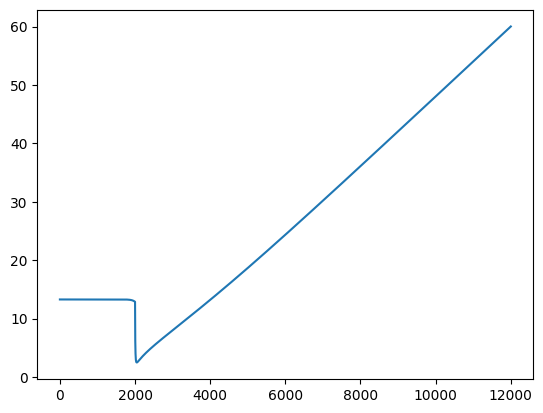

In [152]:
plt.plot(KK)

In [153]:
def get_b(X,m):
	a = 1/np.sqrt(X*m)
	b = 4/np.pi * a - 0.3056*a**3
	b = np.where(np.where(a>1.193,1,b)>=1,1,b)
	return b


In [154]:
Xs1 = np.logspace(-15,-3,2000)
Xs = np.r_[Xs1,np.linspace(1e-3,60,10001)]
# Xs = np.linspace(0.001,60,10000)
R0 = np.nan*Xs
RD = np.nan*Xs
OPs = np.nan*Xs

for i,X in enumerate(Xs):
	b = get_b(X,m)
	OPs[i] = b*X
	R0[i],err = quad(integrand_Rl, -OPs[i],OPs[i],args=(X,0,1,m),limit=200)	
	rd,err = quad(integrand_Rd,OPs[i],np.inf,args=(X,0,1,m),limit=200)
	RD[i] = 2*rd
R = R0 -RD
KK = Xs/R
K_min_arg = np.argmin(KK)

K_d,K_u = KK[:K_min_arg],KK[K_min_arg:]
r_d,r_u = Xs[:K_min_arg]/K_d,Xs[K_min_arg:]/K_u
R_0d,R_0u = R0[:K_min_arg],R0[K_min_arg:]
R_dd,R_du = -RD[:K_min_arg],-RD[K_min_arg:]

R_u = R_0u + R_du
R_d = R_0d + R_dd
K_start = KK[K_min_arg]
Xsu = Xs[K_min_arg:]
Xsd = Xs[:K_min_arg]

a = 1/np.sqrt(Xsu*m)
b = 4/np.pi * a - 0.3056*a**3
b = np.where(np.where(a>1.193,1,b)>=1,1,b)
OPS = b*Xsu

F_K_R_u = interpolate.interp1d(K_u,R_u,fill_value=np.nan,bounds_error=False,kind='cubic')
F_R_u_K = interpolate.interp1d(R_u,K_u,fill_value=np.nan,bounds_error=False,kind='cubic')
F_K_ops = interpolate.interp1d(K_u,OPS,fill_value=np.nan,bounds_error=False,kind='cubic')
F_r_ops = interpolate.interp1d(R,OPs,fill_value=np.nan,bounds_error=False,kind='linear')

In [155]:
print(*map(len,[K_u, R_u, R_0u, OPS]))

9956 9956 9956 9956


In [156]:
F_KR = interpolate.interp1d(K_u,R_u,fill_value=np.nan,bounds_error=False,kind='cubic')
F_KR0 = interpolate.interp1d(K_u,R_0u,fill_value=np.nan,bounds_error=False,kind='cubic')
F_Kops = interpolate.interp1d(K_u,OPS,fill_value=np.nan,bounds_error=False,kind='cubic')

In [157]:

K = 3
r0 = F_KR0(K)
r = F_KR(K)
OP = F_K_ops(K)

In [158]:

def RP_diff_full(rp, K, r0, OP, m):
    try:
        OPs = max(K * rp, 0)
        delta_P = (m * K**2 * r0 * rp) / (2 * (m**2 * OP**2 + 1)) + (K**2 * rp**2) / (4 * OP * (4 * m**2 * OP**2 + 1))

        RP_l, _ = quad(integrand_Rl3, OP, OP + delta_P + OPs, args=(K * rp, OP, delta_P, m), limit=300)
        RP_d, _ = quad(integrand_Rd, OP + delta_P + OPs, np.inf, args=(K * rp, 0, 1, m), limit=300)

        return RP_l - RP_d - rp
    except:
        return np.nan


def RP_l_full(rp, K, r0, OP, m):
    try:
        OPs = max(K * rp, 0)
        delta_P = (m * K**2 * r0 * rp) / (2 * (m**2 * OP**2 + 1)) + (K**2 * rp**2) / (4 * OP * (4 * m**2 * OP**2 + 1))

        RP_l, _ = quad(integrand_Rl3, OP, OP + delta_P + OPs, args=(K * rp, OP, delta_P, m), limit=200)
        return RP_l
    except:
        return np.nan
@jit_integrand_function2
def integrand_rpl(x, X,omega_p,delta_P,m):
    return g(x+omega_p+delta_P,0,1)*np.sqrt(1-((x)/X)**2)

In [159]:
rps = np.r_[np.logspace(-10, -3, 100), np.linspace(0.001, (1 - r0) / 2, 100)]
RP_ls = np.nan*rps
RP_ds = np.nan*rps
for i,rp in enumerate(rps):
	delta_P = (m * K**2 * r0 * rp) / (2 * (m**2 * OP**2 + 1)) + (K**2 * rp**2) / (4 * OP * (4 * m**2 * OP**2 + 1))
	a = 1 / np.sqrt(K * rp * m)
	b = 4 / np.pi * a - 0.3056 * a**3
	b = np.where(a > 1.193, 1, b)
	b = np.where(b >= 1, 1, b)
	OPs = b * K * rp
	RP_ls[i], _ = quad(integrand_rpl, -delta_P, OPs, args=(K * rp, OP, delta_P, m), limit=300)
	RP_ds[i], _ = quad(integrand_Rd, OP + delta_P + OPs, np.inf, args=(K * rp, 0, 1, m), limit=300)
RPs = RP_ls - RP_ds

In [160]:
b_l = (m * K * r0 ) / (2 * (m**2 * OP**2 + 1)) + (K * rps) / (4 * OP * (4 * m**2 * OP**2 + 1))

In [161]:
RP1_d = np.nan*OPS
RP1_u = np.nan*OPS
RPl_d = np.nan*OPS
RPl_u = np.nan*OPS
K1p = np.nan*OPS

for i,(K, r, r0, OP) in enumerate(zip(K_u, R_u, R_0u, OPS)):
	rps = np.r_[np.logspace(-10, -3, 100), np.linspace(0.001, (1 - r0) / 2, 100)]
	diffs = np.array([RP_diff(rp, K, r0, OP, m) for rp in rps])
	sign_change = np.where(np.diff(np.sign(diffs)) != 0)[0]
	K1p[i] = K
	try:
		i1 = sign_change[0]
		if len(sign_change) == 1:
			RP1_d[i] = 0
			RPl_d[i] = 0
		else:
			rp_left = brentq(RP_diff, rps[i1], rps[i1+1], args=(K, r0, OP, m))
			RP1_d[i] = rp_left
			RPl_d[i] = RP_l(rp_left, K, r0, OP, m)
		i2 = sign_change[-1]
		rp_right = brentq(RP_diff, rps[i2-1], rps[i2+1], args=(K, r0, OP, m))

		RP1_u[i] = rp_right
		RPl_u[i] = RP_l(rp_right, K, r0, OP, m)
	except:
		pass

In [162]:
RP1_d_full = np.nan*OPS
RP1_u_full = np.nan*OPS
RPl_d_full = np.nan*OPS
RPl_u_full = np.nan*OPS
K1p_full = np.nan*OPS

for i,(K, r, r0, OP) in enumerate(zip(K_u, R_u, R_0u, OPS)):
	rps = np.r_[np.logspace(-10, -3, 100), np.linspace(0.001, (1 - r0) / 2, 100)]
	diffs = np.array([RP_diff_full(rp, K, r0, OP, m) for rp in rps])
	sign_change = np.where(np.diff(np.sign(diffs)) != 0)[0]
	K1p_full[i] = K
	try:
		i1 = sign_change[0]
		if len(sign_change) == 1:
			RP1_d_full[i] = 0
			RPl_d_full[i] = 0
		else:
			rp_left = brentq(RP_diff_full, rps[i1], rps[i1+1], args=(K, r0, OP, m))
			RP1_d_full[i] = rp_left
			RPl_d_full[i] = RP_l_full(rp_left, K, r0, OP, m)
		i2 = sign_change[-1]
		rp_right = brentq(RP_diff_full, rps[i2-1], rps[i2+1], args=(K, r0, OP, m))

		RP1_u_full[i] = rp_right
		RPl_u_full[i] = RP_l_full(rp_right, K, r0, OP, m)
	except:
		pass

In [163]:
rp_left = []
rp_right = []
K_2p = []

for i,(K, r, r0, OP) in enumerate(list(zip(K_u, R_u, R_0u, OPS))):
	rps = np.r_[np.logspace(-10, -3, 100), np.linspace(0.001, (1 - r0), 100)]
	RP_ls = np.nan*rps
	RP_ds = np.nan*rps
	for i,rp in enumerate(rps):
		delta_P = (m * K**2 * r0 * rp) / (2 * (m**2 * OP**2 + 1)) + (K**2 * rp**2) / (4 * OP * (4 * m**2 * OP**2 + 1))
		a = 1 / np.sqrt(K * rp * m)
		b = 4 / np.pi * a - 0.3056 * a**3
		b = np.where(a > 1.193, 1, b)
		b = np.where(b >= 1, 1, b)
		# OPs =min(0.29728992567957624,K*rp)# b * K * rp
		OPs = b * K * rp

		RP_ls[i], _ = quad(integrand_rpl, -delta_P, OPs, args=(K * rp, OP, delta_P, m), limit=300)
		RP_ds[i], _ = quad(integrand_Rd, OP + delta_P + OPs, np.inf, args=(K * rp, 0, 1, m), limit=300)
	RPs = RP_ls - RP_ds
	arg = ~np.isnan(RPs)
	RPs = RPs[arg]
	rps = rps[arg]
	rp_diff = RPs-rps
	sign_change = np.where(np.diff(np.sign(rp_diff)) != 0)[0]
	# plt.plot(rp_diff)
	
	if len(sign_change) == 1:
		i1 = sign_change[0]
		rp_left.append(rps[i1-1])
		rp_right.append(rps[i1-1])
		K_2p.append(K)
	elif len(sign_change) >= 2:
		i1 = sign_change[0]
		i2 = sign_change[-1]
		rp_left.append(rps[i1-1])
		rp_right.append(rps[i2-1])
		K_2p.append(K)

In [169]:
R_KC = np.load('Simul/R_Kc.npz',allow_pickle=True)
K_cs = R_KC['Kcs']
m_Kc = R_KC['ms']
K_mins = R_KC['K_mins']
def make_empty_array(num,Ks,ms,length):
    EMPTY = []
    for i in np.arange(num):
        EMPTY.append(np.nan*np.zeros((length,101,101)))
    return EMPTY
Ks = np.linspace(0,10,101)
ms = np.linspace(0,10,101)
Rs,R0s,RPs,RMs,RPLs,RMLs,Rstds,N0s,NMs,NPs = make_empty_array(10,Ks,ms,10)
KK,MM = np.meshgrid(Ks,ms)

for i in range(10):
    A = np.load(f'RS_{i+1}.npz')
    Rs[i] = A['N_Rs'].T
    R0s[i] = A['N_R0s'].T
    RPs[i] = A['N_RPs'].T
    RMs[i] = A['N_RMs'].T
    RPLs[i] = A['N_RPLs'].T
    RMLs[i] = A['N_RMLs'].T
    Rstds[i] = A['N_rstd'].T
    N0s[i] = A['N_0s'].T
    NMs[i] = A['N_Ms'].T
    NPs[i] = A['N_Ps'].T

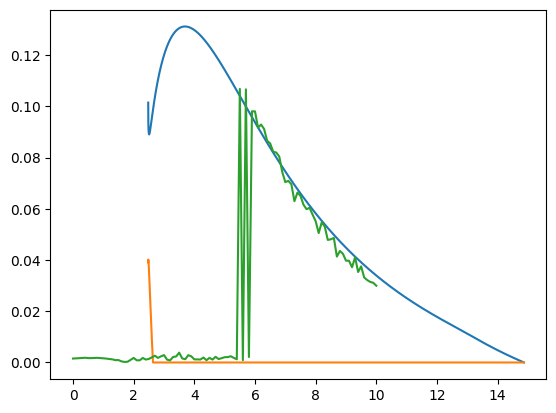

In [170]:
plt.plot(K1p,RP1_u)
plt.plot(K1p,RP1_d)
plt.plot(Ks,RPLs[0][60,:])

# plt.plot(K1p_full,RP1_u_full)
# plt.plot(K1p_full,RP1_d_full)

# plt.plot(K_2p,rp_left)
# plt.plot(K_2p,rp_right)


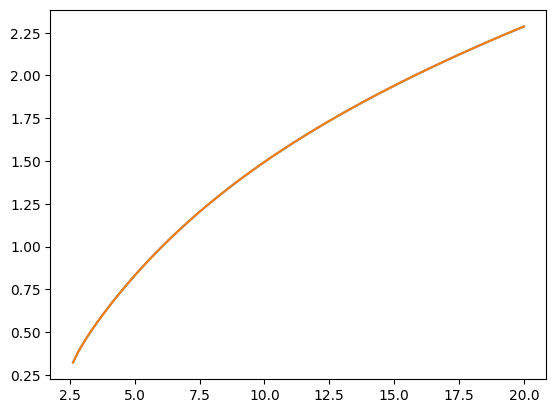

In [171]:
Ks = np.linspace(0,20,100)
plt.plot(Ks,F_r_ops(F_K_R_u(Ks)))
plt.plot(Ks,F_r_ops(F_K_R_u(Ks)))

In [174]:
R0 = np.nan*Xs.copy()
RD = np.nan*Xs.copy()
OPs = np.nan*Xs.copy()

for i,X in enumerate(Xs):
	b = get_b(X,m)
	op = F_r_ops(F_K_R_u(9))
	if b*X <= op:
		omega_p = min(X,op)
		OPs[i] = omega_p
		R0[i],err = quad(integrand_Rl, -omega_p,omega_p,args=(X,0,1,m),limit=200)	
		rd,err = quad(integrand_Rd,omega_p,np.inf,args=(X,0,1,m),limit=200)
		RD[i] = 2*rd
R = R0 -RD
KK = Xs/R
arg = np.where(~np.isnan(R))[0]
Xs = Xs[arg]
R = R[arg]
KK = KK[arg]
K_min_arg = np.argmin(KK)

K_d,K_u = KK[:K_min_arg],KK[K_min_arg:]
r_d,r_u = Xs[:K_min_arg]/K_d,Xs[K_min_arg:]/K_u
R_0d,R_0u = R0[:K_min_arg],R0[K_min_arg:]
R_dd,R_du = -RD[:K_min_arg],-RD[K_min_arg:]

R_u = R_0u + R_du
R_d = R_0d + R_dd
K_start = KK[K_min_arg]
Xsu = Xs[K_min_arg:]
Xsd = Xs[:K_min_arg]
OPS = OPs[K_min_arg:]
F_K_R_b = interpolate.interp1d(K_u,R_u)
F_K_R0_b = interpolate.interp1d(K_u,R_0u)
F_K_ops_b = interpolate.interp1d(K_u,OPS)

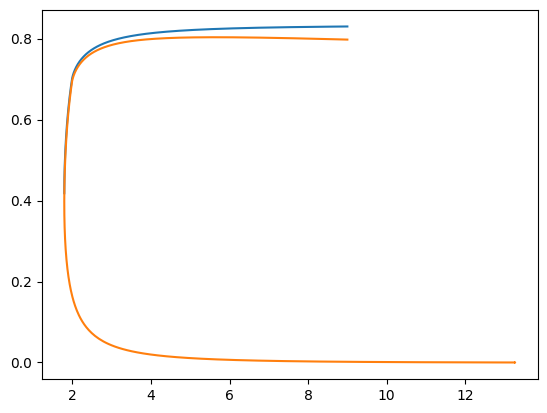

In [175]:
plt.plot(K_u,R_0u)
plt.plot(KK,R)
# plt.xlim(6,9)
# plt.ylim(0.8)

In [176]:

def RP_diff(rp, K, r0, OP, m):
    try:
        a = 1 / np.sqrt(K * rp * m)
        b = 4 / np.pi * a - 0.3056 * a**3
        if a > 1.193: b = 1
        b = min(b, 1)
        OPs = max(b * K * rp, 0)

        delta_P = (m * K**2 * r0 * rp) / (2 * (m**2 * OP**2 + 1)) + (K**2 * rp**2) / (4 * OP * (4 * m**2 * OP**2 + 1))

        RP_l, _ = quad(integrand_Rl3, OP, OP + delta_P + OPs, args=(K * rp, OP, delta_P, m), limit=300)
        RP_d, _ = quad(integrand_Rd, OP + delta_P + OPs, np.inf, args=(K * rp, 0, 1, m), limit=300)

        return RP_l - RP_d - rp
    except:
        return np.nan


def RP_l(rp, K, r0, OP, m):
    try:
        a = 1 / np.sqrt(K * rp * m)
        b = 4 / np.pi * a - 0.3056 * a**3
        if a > 1.193: b = 1
        b = min(b, 1)
        OPs = max(b * K * rp, 0)

        delta_P = (m * K**2 * r0 * rp) / (2 * (m**2 * OP**2 + 1)) + (K**2 * rp**2) / (4 * OP * (4 * m**2 * OP**2 + 1))

        RP_l, _ = quad(integrand_Rl3, OP, OP + delta_P + OPs, args=(K * rp, OP, delta_P, m), limit=200)
        return RP_l
    except:
        return np.nan

def RP_diff_full(rp, K, r0, OP, m):
    try:
        OPs = max(K * rp, 0)

        delta_P = (m * K**2 * r0 * rp) / (2 * (m**2 * OP**2 + 1)) + (K**2 * rp**2) / (4 * OP * (4 * m**2 * OP**2 + 1))

        RP_l, _ = quad(integrand_Rl3, OP, OP + delta_P + OPs, args=(K * rp, OP, delta_P, m), limit=300)
        RP_d, _ = quad(integrand_Rd, OP + delta_P + OPs, np.inf, args=(K * rp, 0, 1, m), limit=300)

        return RP_l - RP_d - rp
    except:
        return np.nan


def RP_l_full(rp, K, r0, OP, m):
    try:
        OPs = max(K * rp, 0)
        delta_P = (m * K**2 * r0 * rp) / (2 * (m**2 * OP**2 + 1)) + (K**2 * rp**2) / (4 * OP * (4 * m**2 * OP**2 + 1))

        RP_l, _ = quad(integrand_Rl3, OP, OP + delta_P + OPs, args=(K * rp, OP, delta_P, m), limit=200)
        return RP_l
    except:
        return np.nan

In [177]:
RP1_d = np.nan*OPS
RP1_u = np.nan*OPS
RPl_d = np.nan*OPS
RPl_u = np.nan*OPS
K1p = np.nan*OPS

for i,(K, r, r0, OP) in enumerate(zip(K_u, R_u, R_0u, OPS)):
	rps = np.r_[np.logspace(-10, -3, 100), np.linspace(0.001, (1 - r0) / 2, 100)]
	diffs = np.array([RP_diff(rp, K, r0, OP, m) for rp in rps])
	sign_change = np.where(np.diff(np.sign(diffs)) != 0)[0]
	K1p[i] = K
	try:
		i1 = sign_change[0]
		if len(sign_change) == 1:
			RP1_d[i] = 0
			RPl_d[i] = 0
		else:
			rp_left = brentq(RP_diff, rps[i1], rps[i1+1], args=(K, r0, OP, m))
			RP1_d[i] = rp_left
			RPl_d[i] = RP_l(rp_left, K, r0, OP, m)
		i2 = sign_change[-1]
		rp_right = brentq(RP_diff, rps[i2-1], rps[i2+1], args=(K, r0, OP, m))

		RP1_u[i] = rp_right
		RPl_u[i] = RP_l(rp_right, K, r0, OP, m)
	except:
		pass

RP1_d_full = np.nan*OPS
RP1_u_full = np.nan*OPS
RPl_d_full = np.nan*OPS
RPl_u_full = np.nan*OPS
K1p_full = np.nan*OPS

for i,(K, r, r0, OP) in enumerate(zip(K_u, R_u, R_0u, OPS)):
	rps = np.r_[np.logspace(-10, -3, 100), np.linspace(0.001, (1 - r0) / 2, 100)]
	diffs = np.array([RP_diff_full(rp, K, r0, OP, m) for rp in rps])
	sign_change = np.where(np.diff(np.sign(diffs)) != 0)[0]
	K1p_full[i] = K
	try:
		i1 = sign_change[0]
		if len(sign_change) == 1:
			RP1_d_full[i] = 0
			RPl_d_full[i] = 0
		else:
			rp_left = brentq(RP_diff_full, rps[i1], rps[i1+1], args=(K, r0, OP, m))
			RP1_d_full[i] = rp_left
			RPl_d_full[i] = RP_l_full(rp_left, K, r0, OP, m)
		i2 = sign_change[-1]
		rp_right = brentq(RP_diff_full, rps[i2-1], rps[i2+1], args=(K, r0, OP, m))

		RP1_u_full[i] = rp_right
		RPl_u_full[i] = RP_l_full(rp_right, K, r0, OP, m)
	except:
		pass

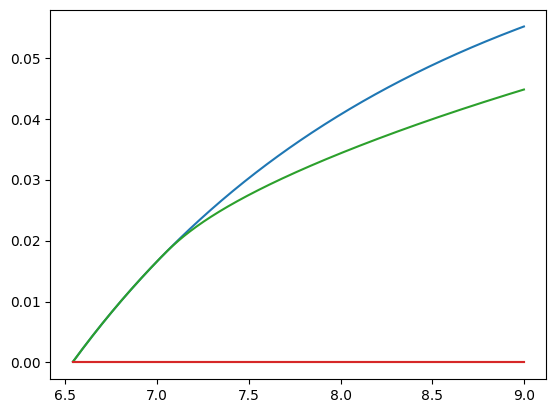

In [178]:
plt.plot(K1p_full,RP1_u_full)
plt.plot(K1p_full,RP1_d_full)
plt.plot(K1p,RP1_u)
plt.plot(K1p,RP1_d)


In [179]:
def get_omega_mean(O_p,b):
    return (norm.pdf(O_p) - norm.pdf(b)) /(norm.cdf(b) - norm.cdf(O_p))

In [180]:
a = 1 / np.sqrt(K1p * RP1_u * m)
b = 4 / np.pi * a - 0.3056 * a**3
b = np.where(a > 1.193, 1, b)
b = np.where(b >= 1, 1, b)
OP_p = b*K1p*RP1_u
Op = OP_p[~np.isnan(OP_p)][-1]
delta_P = (m * K1p**2 * R_0u * RP1_u) / (2 * (m**2 * OPS**2 + 1)) + (K1p**2 * RP1_u**2) / (4 * OPS * (4 * m**2 * OPS**2 + 1))
delta_p = delta_P[~np.isnan(delta_P)][-1]

In [181]:
b[-1]

0.7374273727409347

In [182]:
OP_p[-1]

0.29728992567957624

In [183]:
op =0.29728992567957624

In [184]:
K, r, r0, OP = K_u[-1], R_u[-1], R_0u[-1], OPS[-1]
print(K, r, r0, OP)

8.999667662342029 0.7974606029098995 0.8298790607403167 1.3847862686618726


In [185]:
K = 7
r0 = F_K_R0_b(K)
r = F_K_R_b(K)
OP = F_K_ops_b(K)
op,O2 = 0.29728992567957624,0.4263720196999615

In [186]:
delta_p

0.12908209402038526

In [187]:
@jit_integrand_function2
def integrand_rpl(x, X,omega_p,delta_P,m):
    return g(x+omega_p+delta_P,0,1)*np.sqrt(1-((x)/X)**2)

In [192]:
rps = np.r_[np.logspace(-10, -3, 100), np.linspace(0.001, (1 - r0)/2, 100)]
RP_ls = np.nan*rps
RP_ds = np.nan*rps
OPs = np.nan*rps
for i,rp in enumerate(rps):
	delta_P = (m * K**2 * r0 * rp) / (2 * (m**2 * OP**2 + 1)) + (K**2 * rp**2) / (4 * OP * (4 * m**2 * OP**2 + 1))
	OPs_ = op
	O2_ = O2
	# OPs =min(0.29728992567957624,K*rp)# b * K * rp
	OPs[i] = OPs_

	RP_ls[i], _ = quad(integrand_rpl, -delta_P, OPs[i], args=(K * rp, OP, delta_P, m), limit=300)
	RP_ds[i], _ = quad(integrand_Rd, OP + O2_, np.inf, args=(K * rp, 0, 1, m), limit=300)
RPs = RP_ls - RP_ds

/var/folders/kn/fvpnhvjx5d363mgqcf9f1ltc0000gn/T/ipykernel_99742/592952091.py:12: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  RP_ls[i], _ = quad(integrand_rpl, -delta_P, OPs[i], args=(K * rp, OP, delta_P, m), limit=300)


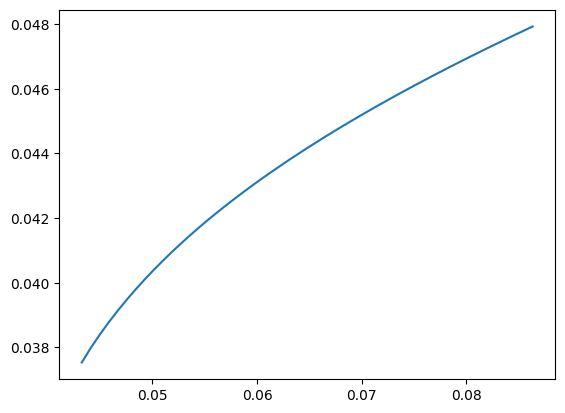

In [193]:
plt.plot(rps,RPs)

In [189]:
delta_Ps = (m * K**2 * r0 * rps) / (2 * (m**2 * OP**2 + 1)) + (K**2 * rps**2) / (4 * OP * (4 * m**2 * OP**2 + 1))

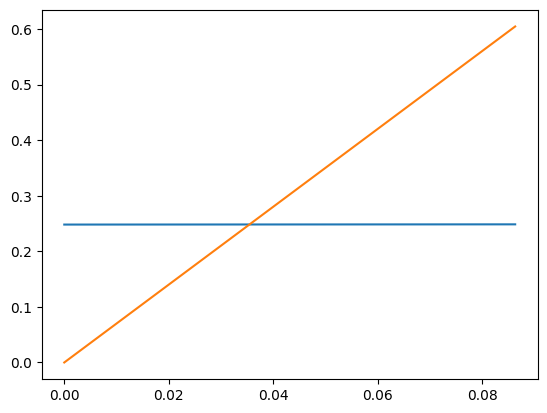

In [190]:
plt.plot(rps,delta_Ps/(K*rps))
plt.plot(rps,(K*rps))
# plt.plot(rps,delta_Ps+K*rps)
# plt.axhline(op)

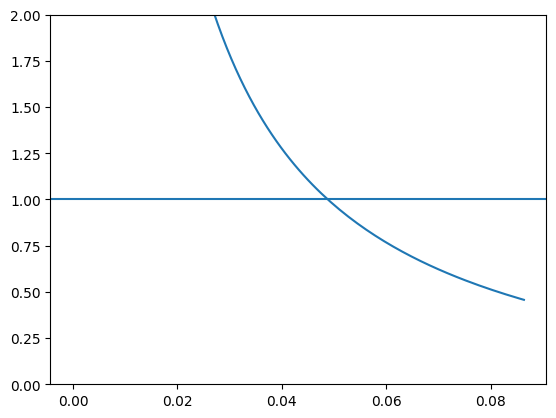

In [687]:
plt.plot(rps,(O2-delta_Ps)/(K*rps))
plt.ylim(0,2)
plt.axhline(1)
# plt.plot(rps,K*rps)

In [643]:
F_Krp = interpolate.interp1d(Ks,Rps)

In [644]:
F_Krp(K)

array(0.03904091)

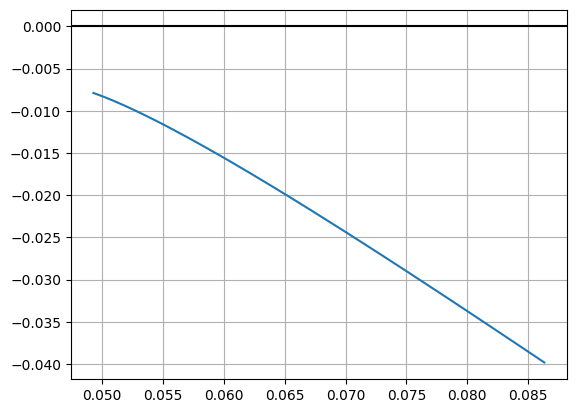

In [690]:
plt.plot(rps,RPs-rps)
# plt.ylim(-0.0005,0.0001)
# plt.xlim(0,0.03)
plt.axhline(0,color='black')
plt.grid()

In [411]:
rps = np.r_[np.logspace(-10, -3, 100), np.linspace(0.001, (1 - r0) / 2, 100)]
RP_ls = np.nan*rps
RP_ds = np.nan*rps
for i,rp in enumerate(rps):
	delta_P = (m * K**2 * r0 * rp) / (2 * (m**2 * OP**2 + 1)) + (K**2 * rp**2) / (4 * OP * (4 * m**2 * OP**2 + 1))
	a = 1 / np.sqrt(K * rp * m)
	b = 4 / np.pi * a - 0.3056 * a**3
	b = np.where(a > 1.193, 1, b)
	b = np.where(b >= 1, 1, b)
	OPs = b * K * rp
	RP_ls[i], _ = quad(integrand_rpl, -delta_P, OPs, args=(K * rp, OP, delta_P, m), limit=300)
	RP_ds[i], _ = quad(integrand_Rd, OP + delta_P + OPs, np.inf, args=(K * rp, 0, 1, m), limit=300)
RPs = RP_ls - RP_ds

In [412]:
rps = np.r_[np.logspace(-10, -3, 100), np.linspace(0.001, (1 - r0) / 2, 100)]
RP_ls2 = np.nan*rps
RP_ds2 = np.nan*rps
for i,rp in enumerate(rps):
	a = 1 / np.sqrt(K * rp * m)
	b = 4 / np.pi * a - 0.3056 * a**3
	if a > 1.193: b = 1
	b = min(b, 1)
	OPs = max(b * K * rp, 0)

	delta_P = (m * K**2 * r0 * rp) / (2 * (m**2 * OP**2 + 1)) + (K**2 * rp**2) / (4 * OP * (4 * m**2 * OP**2 + 1))

	RP_ls2[i], _ = quad(integrand_Rl3, OP, OP + delta_P + OPs, args=(K * rp, OP, delta_P, m), limit=300)
	RP_ds2[i], _ = quad(integrand_Rd, OP + delta_P + OPs, np.inf, args=(K * rp, 0, 1, m), limit=300)
RPs2 = RP_ls2 - RP_ds2


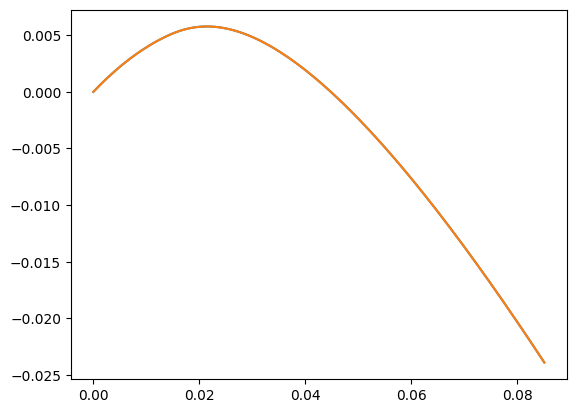

In [413]:
plt.plot(rps,RPs-rps)
plt.plot(rps,RPs2-rps)

In [241]:
RPs = RP_ls - RP_ds
arg = ~np.isnan(RPs)
RPs = RPs[arg]
rps = rps[arg]
OPs = OPs[arg]
rp_diff = RPs-rps
sign_change = np.where(np.diff(np.sign(rp_diff)) != 0)[0]

In [250]:
rp_

0.07445656957743821

In [249]:
i1 = sign_change[0]
OPs[i1-1]
rp_ = rps[i1-1]
delta_P = (m * K**2 * r0 * rp_) / (2 * (m**2 * OP**2 + 1)) + (K**2 * rp_) / (4 * OP * (4 * m**2 * OP**2 + 1))
a = 1 / np.sqrt(K * rp_ * m)
b = 4 / np.pi * a - 0.3056 * a**3
b = np.where(a > 1.193, 1, b)
b = np.where(b >= 1, 1, b)
b * K * rp_
# OPs[i1-1] = b * K * rp_

0.400098045025845

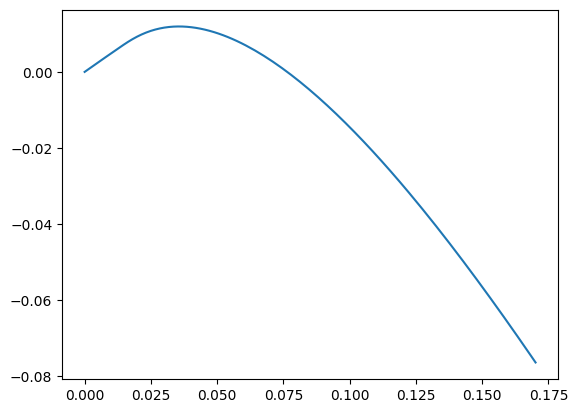

In [244]:
plt.plot(rps,rp_diff)

In [556]:
O2 = delta_p + op

In [621]:
O2

0.4263720196999615

In [ ]:
rp_left = []
rp_right = []
K_2p = []

for i,(K, r, r0, OP) in enumerate(list(zip(K_u, R_u, R_0u, OPS))[::-1]):
	rps = np.r_[np.logspace(-10, -3, 100), np.linspace(0.001, (1 - r0)/2, 100)]
	RP_ls = np.nan*rps
	RP_ds = np.nan*rps
	for i,rp in enumerate(rps):
		delta_P = (m * K**2 * r0 * rp) / (2 * (m**2 * OP**2 + 1)) + (K**2 * rp**2) / (4 * OP * (4 * m**2 * OP**2 + 1))
		O2_ = min(2*K*rp,O2) 
		# delta_P = delta_p
		# b = np.where(b >= 1, 1, b)
		# O2_ =min(O2,K*rp)# b * K * rp
		# if K*rp < op-delta_P:
			# delta_P = (m * K**2 * r0 * rp) / (2 * (m**2 * OP**2 + 1)) + (K**2 * rp**2) / (4 * OP * (4 * m**2 * OP**2 + 1))
			# OPs = K*rp
		# OPs = b * K * rp

		RP_ls[i], _ = quad(integrand_Rl3, OP, OP + O2_, args=(K * rp, OP, delta_P, m), limit=300)
		RP_ds[i], _ = quad(integrand_Rd, OP + O2_, np.inf, args=(K * rp, 0, 1, m), limit=300)
	RPs = RP_ls - RP_ds
	arg = ~np.isnan(RPs)
	RPs = RPs[arg]
	rps = rps[arg]
	rp_diff = RPs-rps
	sign_change = np.where(np.diff(np.sign(rp_diff)) != 0)[0]
	plt.plot(rp_diff)
	
	if len(sign_change) == 1:
		i1 = sign_change[0]
		rp_left.append(rps[i1-1])
		rp_right.append(rps[i1-1])
		K_2p.append(K)
	elif len(sign_change) >= 2:
		i1 = sign_change[0]
		i2 = sign_change[-1]
		rp_left.append(rps[i1-1])
		rp_right.append(rps[i2-1])
		K_2p.append(K)

C:\Users\kim9y\AppData\Local\Temp\ipykernel_30020\421809983.py:20: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  RP_ls[i], _ = quad(integrand_Rl3, OP, OP + O2_, args=(K * rp, OP, delta_P, m), limit=300)


In [590]:
np.diff(np.sign(rp_diff))

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

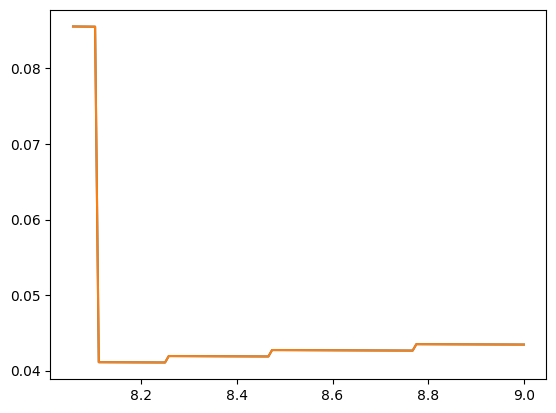

In [591]:
plt.plot(K_2p,rp_left)
plt.plot(K_2p,rp_right)

In [38]:
A = OPS[~np.isnan(OPS)]
B = OPS + delta_P + OP_p
B = B[~np.isnan(B)]

In [40]:
get_omega_mean(A[-1],B[-1]) - A[-1]

0.18930611193253055

In [42]:
delta_P[~np.isnan(delta_P)][-1]

0.1290820940203853

ValueError: operands could not be broadcast together with shapes (1079,) (80,) 

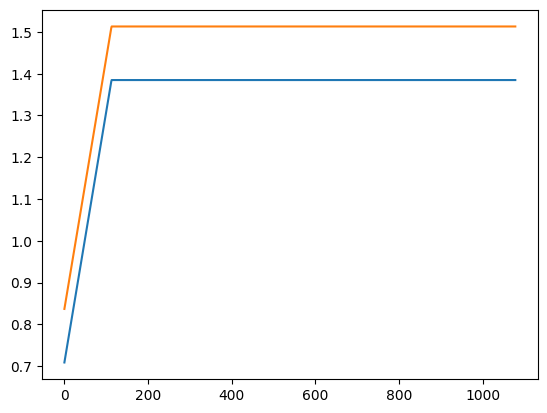

In [562]:
plt.plot(OPS)
plt.plot(OPS + delta_P)
plt.plot(OPS + delta_P + OP_p)

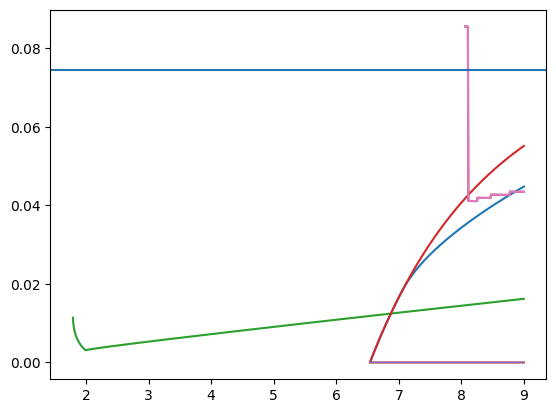

In [593]:
plt.plot(K1p,RP1_u)
plt.plot(K1p,RP1_d)
plt.plot(K1p,-R_du/2)
plt.plot(K1p_full,RP1_u_full)
plt.plot(K1p_full,RP1_d_full)

plt.plot(K_2p,rp_left)
plt.plot(K_2p,rp_right)
plt.axhline(rp_)

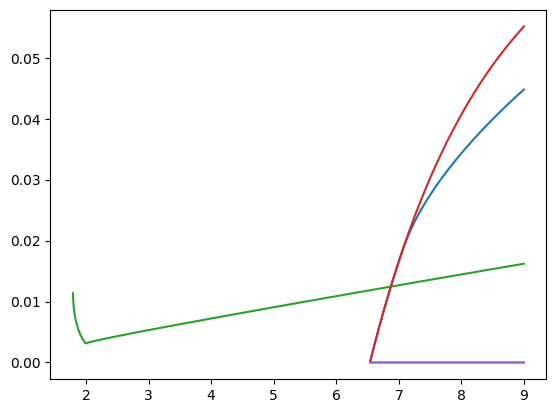

In [592]:
plt.plot(K1p,RP1_u)
plt.plot(K1p,RP1_d)
plt.plot(K1p,-R_du/2)
plt.plot(K1p_full,RP1_u_full)
plt.plot(K1p_full,RP1_d_full)

(0.0, 1.0)

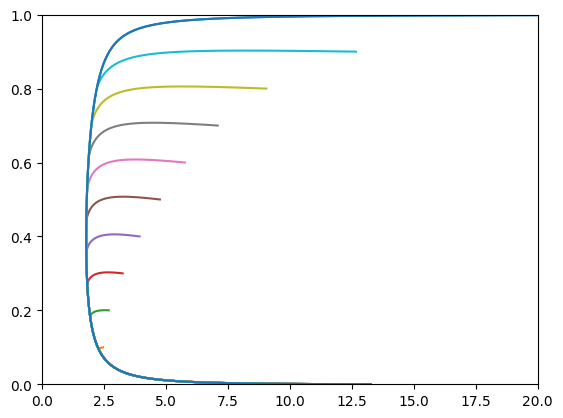

In [171]:
rs = np.linspace(0.,1,11)
for r in rs:
	Xs1 = np.logspace(-15,-3,2000)
	Xs = np.r_[Xs1,np.linspace(1e-3,60,10001)]
	op = F_r_ops(r)
	if r == 1:
		op = 100
	R_ls = []
	R_drs = []
	for X in Xs:
		a = 1/np.sqrt(X*m)
		b = 4/np.pi * a - 0.3056*a**3
		b = np.where(np.where(a>1.193,1,b)>=1,1,b)
		omega_p = min(X,max(b*X,op))
		# omega_p = max(b*X,op)
		omega_p = min(X,op)
		if b*X > op:
			R_l = np.nan
			R_d = np.nan
		else:
			R_l,err = quad(integrand_Rl, -omega_p,omega_p,args=(X,0,1,m),limit=200)
			R_dr,err = quad(integrand_Rd,omega_p,np.inf,args=(X,0,1,m),limit=200)
		R_ls.append(R_l)
		R_drs.append(R_dr)
	# plt.axhline(r)
	R0 = np.array(R_ls)
	RD = 2*np.array(R_drs)
	R = R0 -RD
	KK = 1/(R/Xs)
	plt.plot(KK,R)
plt
plt.xlim(0,20)
plt.ylim(0,1)

In [194]:
from TO_sim.get_rrrp import get_K_r_rp,get_K_r_rp_full
import numpy as np
import matplotlib.pyplot as plt
from TO_sim.get_simul import get_r_y
from TO_sim.gen_Distribution import Quantile_Normal as Q_Normal
from tqdm.notebook import tqdm

In [195]:
K = 0
seed = 11
N = 5000
m = 6
theta_random,omega,Kc = Q_Normal(N,0,1,seed=seed)
omega = omega - np.mean(omega)
omega = np.sort(omega)
Y = np.r_[theta_random,theta_random]

In [196]:
r0,rp,rm,rs,rpl,rml,N0,NP,NM,rstd,Y,avg_theta,c_s = get_r_y(9,m,Y,omega,N,tend=10100)

In [447]:
RP1_u[~np.isnan(RP1_u)][-1]-rp

0.002424996593980669

In [197]:
Ks = np.arange(9,5,-0.05)
r0s = []
Rps = []
rms = []
rss = []

rpls = []
rmls = []
N0s = []
NPs = []
NMs = []

c_ss = []
avg_thetas = []
y_s = []

for K in tqdm(Ks):
    r0,rp,rm,rs,rpl,rml,N0,NP,NM,rstd,Y,avg_theta,c_s = get_r_y(K,m,Y,omega,N,tend=2500)
    r0s.append(r0)
    Rps.append(rp)
    rms.append(rm)
    rss.append(rs)
    rpls.append(rpl)
    rmls.append(rml)
    N0s.append(N0)
    NPs.append(NP)
    NMs.append(NM)
    c_ss.append(c_s)
    avg_thetas.append(avg_theta)
    y_s.append(Y.copy())

  0%|          | 0/80 [00:00<?, ?it/s]

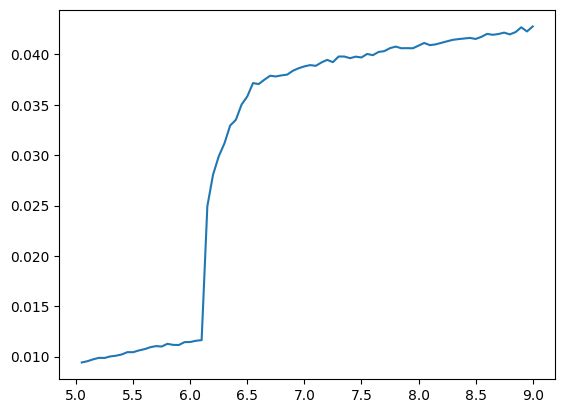

In [199]:
# plt.plot(K_2p,rp_left)
# plt.plot(K_2p,rp_right)
plt.plot(Ks,Rps)


In [ ]:
b = 4/np.pi * 1/np.sqrt(K_u*rpk*m) - 0.3056 * (1/np.sqrt(K_u*rps*m))**3

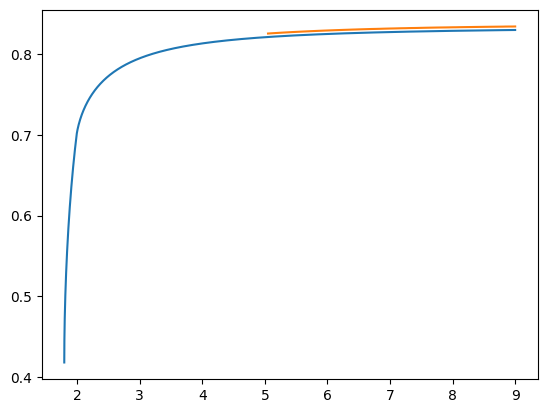

In [511]:

plt.plot(K1p,R_0u)
plt.plot(Ks,r0s)

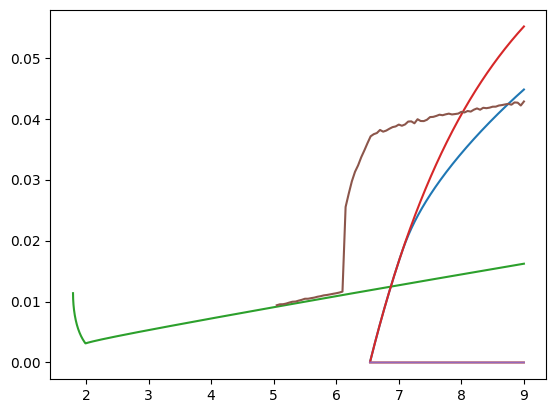

In [477]:
plt.plot(K1p,RP1_u)
plt.plot(K1p,RP1_d)
plt.plot(K1p,-R_du/2)
plt.plot(K1p_full,RP1_u_full)
plt.plot(K1p_full,RP1_d_full)
plt.plot(Ks,Rps)

In [93]:
c_s['+l']

array([1853, 1854, 1855, 1857], dtype=int64)

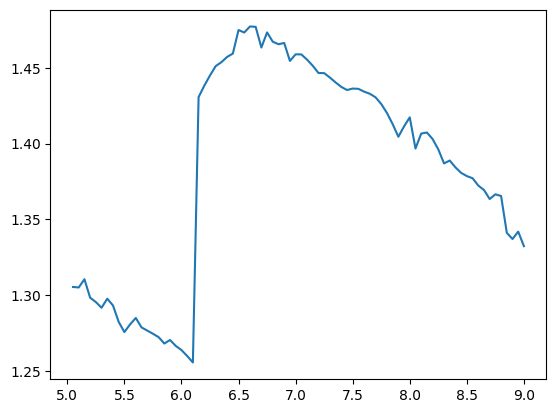

In [200]:
v_p = []
OP_ = []
OP_p = []
for i in range(len(Ks)):
	c_s = c_ss[i]
	v = np.array(avg_thetas[i])
	if len(c_s['+l']) > 0:
		v_p.append(np.mean(v[c_s['+l']]))
		OP_.append(np.min(omega[c_s['+l']]))
		OP_p.append(np.max(omega[c_s['+l']]))
	else:
		v_p.append(np.nan)
		OP_.append(np.nan)
		OP_p.append(np.nan)
plt.plot(Ks,v_p)
	

In [ ]:
delta_P = (m * Ks**2 * np.array(r0s) * np.array(Rps)) / (2 * (m**2 * np.array(OP)**2 + 1)) + (Ks**2 * np.array(Rps)**2) / (4 * np.array(OP) * (4 * m**2 * np.array(OP)**2 + 1))


In [210]:
Ks

array([9.  , 8.95, 8.9 , 8.85, 8.8 , 8.75, 8.7 , 8.65, 8.6 , 8.55, 8.5 ,
       8.45, 8.4 , 8.35, 8.3 , 8.25, 8.2 , 8.15, 8.1 , 8.05, 8.  , 7.95,
       7.9 , 7.85, 7.8 , 7.75, 7.7 , 7.65, 7.6 , 7.55, 7.5 , 7.45, 7.4 ,
       7.35, 7.3 , 7.25, 7.2 , 7.15, 7.1 , 7.05, 7.  , 6.95, 6.9 , 6.85,
       6.8 , 6.75, 6.7 , 6.65, 6.6 , 6.55, 6.5 , 6.45, 6.4 , 6.35, 6.3 ,
       6.25, 6.2 , 6.15, 6.1 , 6.05, 6.  , 5.95, 5.9 , 5.85, 5.8 , 5.75,
       5.7 , 5.65, 5.6 , 5.55, 5.5 , 5.45, 5.4 , 5.35, 5.3 , 5.25, 5.2 ,
       5.15, 5.1 , 5.05])

In [212]:
A = np.sqrt(1 - Ks**2 * np.array(rss)**2/(m**2 +OP**2 +1)/OP**2) * OP
delta_P_temp = (m * Ks**2 * np.array(r0s) * np.array(Rps)) / (2 * (m**2 * np.array(OP)**2 + 1)) + (Ks**2 * np.array(Rps)**2) / (4 * np.array(OP) * (4 * m**2 * np.array(OP)**2 + 1))
delta_P = (m * Ks**2 * np.array(r0s) * np.array(Rps)) / (2 * (m**2 * np.array(A)**2 + 1)) + (Ks**2 * np.array(Rps)**2) / (4 * np.array(A) * (4 * m**2 * np.array(A)**2 + 1))


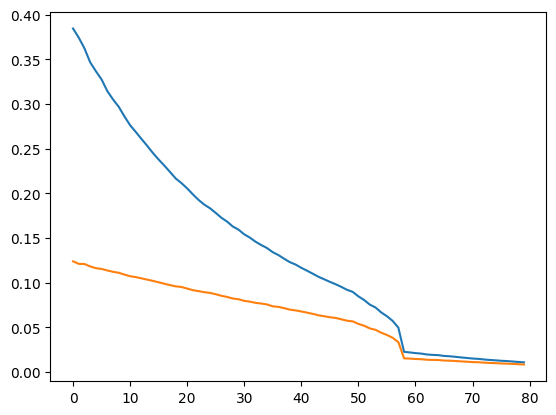

In [220]:
plt.plot(delta_P)
plt.plot(delta_P_temp)

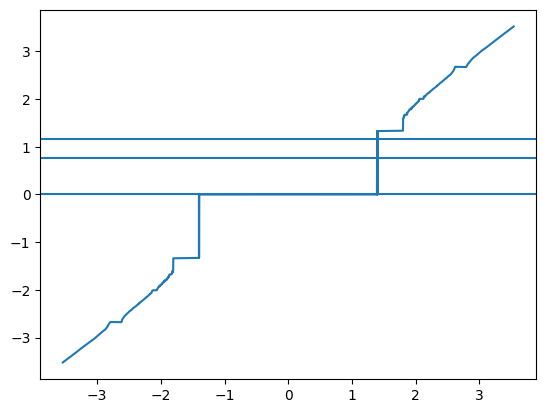

In [219]:
idx = 0
plt.plot(omega,avg_thetas[idx])
# plt.axhline(OP_p[idx])
# plt.axhline(OP_[idx])
plt.axhline(A[idx])
plt.axhline(A[idx]+delta_P[idx])

# plt.axvline(OPS[-1] + O2_)
# plt.axvline(OPS[-1] )
# plt.axvline(OPS[-1] +2*Ks[idx]*Rps[idx],color='red')
# plt.axvline(OPS[-1] + delta_P[-1] + OP_p[-1])
# plt.axvline(OPS[-1])
# plt.axvline(OPS[-1]+delta_P[-1])

# plt.axhline(OP[-1])
plt.axhline()

In [601]:
delta_P = (m * Ks**2 * np.array(r0s) * np.array(Rps)) / (2 * (m**2 * np.array(OP)**2 + 1)) + (Ks**2 * np.array(Rps)**2) / (4 * np.array(OP) * (4 * m**2 * np.array(OP)**2 + 1))

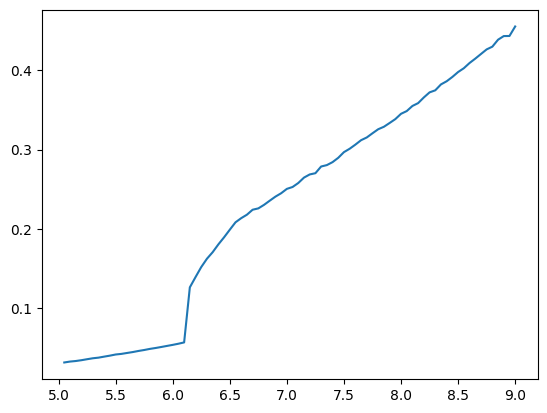

In [505]:
plt.plot(Ks,delta_P)
# plt.plot(Ks,OP+delta_P)

In [454]:
op = 0.29728992567957624

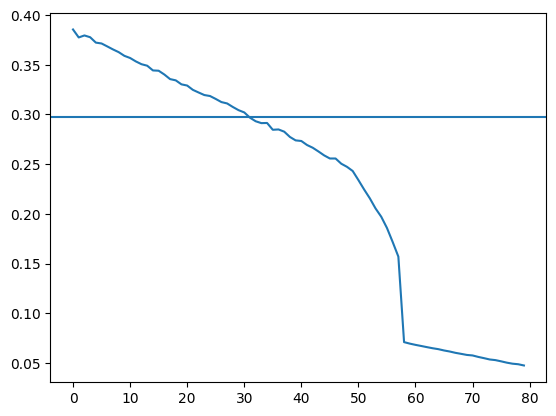

In [455]:
np.where(Ks*np.array(Rps)>op,op,Ks*np.array(Rps))
plt.plot(Ks*Rps)
plt.axhline(op)

In [600]:
delta_P

0.0627825503354725

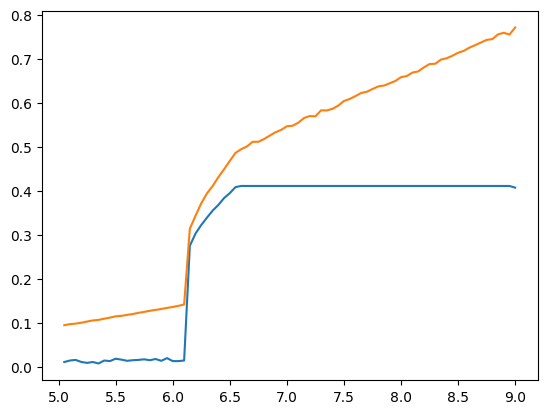

In [606]:
plt.plot(Ks,np.array(OP_p)-OP_)
plt.plot(Ks,2*Ks*np.array(Rps))


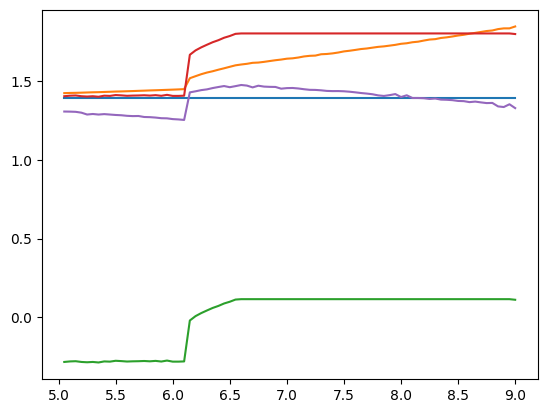

In [603]:
plt.plot(Ks,OP_)
plt.plot(Ks,OP_+delta_P)
# plt.plot(Ks,OP_+np.where(Ks*np.array(Rps)>op,op,Ks*np.array(Rps)))
# plt.plot(Ks,OP_p)
plt.plot(Ks,np.array(OP_p)-op-OP_)
plt.plot(Ks,np.array(OP_p))
# plt.plot(Ks,OP+delta_P[-1]+2*Ks*np.array(rps))
# plt.plot(Ks,OP_p-np.where(Ks*np.array(Rps)>op,op,Ks*np.array(Rps)))
# plt.plot(Ks,OP+Ks*np.array(Rps))
# plt.plot(Ks,OP+2*Ks*np.array(Rps)-delta_P)
# plt.plot(Ks,OP_+delta_P+Ks*np.array(Rps))
# plt.plot(Ks,OP_+delta_P+op)
# plt.plot(Ks,np.array(OP_)+delta_P+op)
# plt.plot(Ks,OP_p-delta_P-Ks*np.array(Rps))

plt.plot(Ks,v_p)


In [ ]:
N = 200
A =  4.9087 * 1e-4
B = 0.0599



In [ ]:
4908 /500